# TP5 : Mesure de l’absorption de la lumière par des liquides
### Auteur : ARGUELLO Camilo

### Introduction

Dans ce TP, notre objectif est d'estimer les coefficients selon la loi de Beer-Lambert. Pour cela, nous utiliserons un montage expérimental avec l'application [PhyPhox](https://phyphox.org/), qui nous permettra de mesurer l'intensité lumineuse $I$ à l'aide d'un liquide sombre (soda de concentration inconnue). Ensuite, nous estimerons ces coefficients en utilisant trois méthodes différentes. Enfin, nous analyserons la méthode qui nous donne les valeurs les plus proches des vraies valeurs.

### Loi de Beer-Lambert

La loi de Beer-Lambert est une loi qui décrit l'absorption de la lumière par un milieu. Elle est donnée par l'équation suivante:

$$I = I_0 \; e^{-\epsilon \cdot l \cdot C} = I_0 \; e^{-\mu \cdot l}$$

Où $I_0$ est l'intensité lumineuse incidente, $I$ est l'intensité lumineuse transmise, $\epsilon$ est le coefficient d'absorption molaire, $l$ est l'épaisseur du milieu, et $C$ est la concentration du milieu.


À l'aide de cette relation, nous allons estimer **le coefficient d'absorption molaire et la concentration $\mu = \epsilon \cdot C$, ainsi que l'intensité $I_0$**, à partir de données expérimentales mesurées avec le capteur de luminosité de notre smartphone, en fonction des longueurs connues de liquide traversées par la lumière.

#### Détermination de la position du capteur de luminosité


Pour réaliser cette expérience, nous utiliserons l'application Phyphox sur notre smartphone avec sa fonction de mesure de luminosité. En accédant à l'onglet 'Composantes' de l'application, nous positionnerons le capteur sous la source lumineuse. Ce dernier nous fournira alors une mesure de luminosité exprimée en lux.

Afin de vérifier le bon étalonnage du capteur, nous placerons notre doigt sous le capteur et vérifierons que l'intensité lumineuse mesurée est égale à 0 ($l_x = 0$).

**Remarque**: Que se passe-t-il si, lorsque nous plaçons notre doigt sur le capteur, il ne marque pas 0?

> Dans ce cas, nous devons prendre cette valeur comme une incertitude sur la mesure de luminosité.

### Montage et protocole expérimental

Le montage expérimental est composé d'une source de lumière (lampe), d'un liquide (soda) et d'un capteur qui mesure l'intensité lumineuse (téléphone). La source de lumière est une LED blanche qui émet de la lumière dans le visible. Le liquide est contenu dans un bécher, accompagné d'un mètre pour mesurer les hauteurs du liquide. Le montage est illustré dans la figure ci-dessous.

![Mesure Illustration](https://camiloarguello.xyz/img/mesure-illustration1.jpg)

1. L'expériment doit se faire dans un endroit sombre afin d'éviter toute interférence de la lumière ambiante avec les mesures.
   
2. Nous plaçons le bécher sur le capteur (téléphone), en dessous de la source de lumière. Ils doivent être alignés de manière à ce que la lumière traverse le liquide et parvienne au capteur.

3. Nous démarrons la collecte des données de luminosité avec l'application Phyphox. Ensuite, nous mesurons différentes longueurs de liquide dans le bécher, en prenant soin de ne pas déplacer le bécher ni de renverser de liquide sur le smartphone. Nous utiliserons la fonctionnalité de contrôle à distance pour cette opération.

4. Nous répétons les mesures pour différentes longueurs de liquide, en prenant toujours les mêmes précautions.

Selon le protocole expérimental, la hauteur de la solution liquide est mesurée à l'aide d'un mètre.

Nous estimons donc l'erreur sur la lecture de la hauteur à $\Delta h \approx \pm 0.1 \ cm$.

Pour estimer une erreur sur la luminosité, nous plaçons un objet sombre devant la lampe pour bloquer la lumière, puis nous le déplaçons. Cette opération est répétée plusieurs fois, en tenant compte notamment de la position du bécher au-dessus du téléphone. Nous constatons que lorsque nous plaçons un objet sombre devant la lampe, l'intensité lumineuse diminue.

Le niveau d'erreur sur la luminosité que nous retiendrons par la suite est de $\Delta l \approx \pm 16.4 \ Lx$.

![Niveux de liquide avec des erreurs](https://camiloarguello.xyz/img/glass-levels.jpg)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qexpy
from qexpy import MeasurementArray
import qexpy.plotting as qplt
from scipy.optimize import minimize
from IPython.display import display, Math

In [2]:
def load_data(folder_path, color='blue'):
    """
    Cette fonction charge les données des fichiers csv dans un dictionnaire
    @param folder_path: chemin du dossier contenant les données
    @param color: couleur de liquide (on a testé avec 3 couleurs différents bleu, rouge, jaune) des données à charger 
    """
    Color={}
    for folder_name in os.listdir(folder_path):
        folder_path_full = os.path.join(folder_path, folder_name)
        if os.path.isdir(folder_path_full):
            raw_data_path = os.path.join(folder_path_full, 'Raw Data.csv')
            if os.path.isfile(raw_data_path):
                var_name = extract_number(folder_name, color)
                Color[var_name] = pd.read_csv(raw_data_path)
    return Color

def extract_number(folder_name, color='yellow'):
    """
    Cette fonction extrait le nom de color avec son numéro pour nommer la colonne
    @param folder_name: nom du dossier
    @param color: couleur à extraire
    """
    substrings = folder_name.split(color)
    if len(substrings) > 1:
        color_number = substrings[1]
        return f'{color}{color_number}'
    else:
        return None

Nous réalisons une série de **6 mesures** correspondant à **6 hauteurs** de liquide différentes. Nous allons stocker les données dans un `dict` selon le format suivant :

```python
data = {
    'blue10': [...['Temps (s)'], ...['Illuminance (lx)']], # mesures pour la hauteur de 1 cm
    'blue20': [...], # mesures pour la hauteur de 2 cm
    'blue30': [...], # mesures pour la hauteur de 3 cm
    'blue40': [...], # mesures pour la hauteur de 4 cm
    'blue50': [...], # mesures pour la hauteur de 5 cm
    'blue60': [...]  # mesures pour la hauteur de 6 cm
}
```

In [3]:
folder_path = './data/Blue/'
Data = load_data(folder_path, color='blue')

heights = np.array([1.05, 2.03, 3.08, 4.03, 5.07, 6.05]) # Hauteur des liquides mésurés en cm
height_uncertainty = 0.1 * np.ones(len(heights)) # Incertitude sur la hauteur des liquides

**Nous utiliserons la moyenne des valeurs de luminosité pour chaque hauteur**, étant donné que l'application Phyphox nous fournit un tableau au cours du temps pour chaque mesure, et que nous avons vérifié la stabilité de nos mesures.

In [4]:
luminosites = np.array([Data[key]['Illuminance (lx)'].mean() for key in sorted(Data.keys())])
luminosite_uncertainty = 16.4 * np.ones(len(luminosites)) # Incertitude sur la luminosité

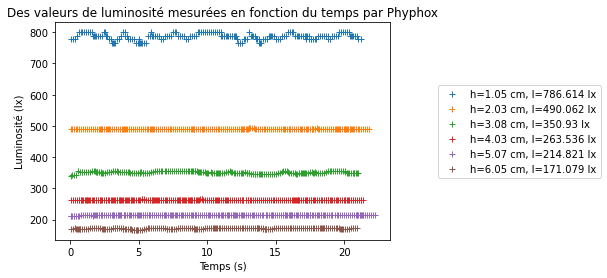

In [5]:
fig, ax = plt.subplots()

for i, height in enumerate(list(sorted(Data.keys())), start=0):
    ax.plot(Data[height]['Time (s)'], Data[height]['Illuminance (lx)'], '+', 
            label=f'h={heights[i]} cm, l={np.round(luminosites[i], 3)} lx')
    
plt.title('Des valeurs de luminosité mesurées en fonction du temps par Phyphox')
plt.xlabel('Temps (s)')
plt.ylabel('Luminosité (lx)')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Erreurs relatives sur les hauteurs: 3.97 %
Erreurs relatives sur les luminosités 5.59 %


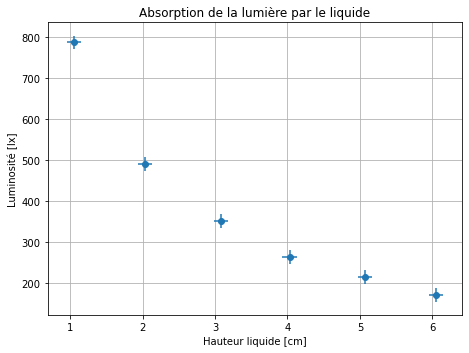

In [6]:
xs = MeasurementArray(heights, height_uncertainty, unit='cm', name='Hauteur liquide ')
ys = MeasurementArray(luminosites, luminosite_uncertainty, unit='lx', name='Luminosité ')

# Erreurs relatives sur les hauteurs et les luminosités
dxs = height_uncertainty / heights
dys = luminosite_uncertainty / luminosites

print('Erreurs relatives sur les hauteurs: {:.2f} %'.format(np.mean(dxs) * 100))
print('Erreurs relatives sur les luminosités {:.2f} %'.format(np.mean(dys) * 100))

qplt.plot(xs, ys)
figure = qplt.get_plot()
figure.title = 'Absorption de la lumière par le liquide'
qplt.show()

D'après le graphique, nous observons une fonction exponentielle décroissante, ce qui confirme l'expression de la loi de Beer-Lambert. De plus, l'erreur qui semble être prédominante est celle portant sur l'intensité lumineuse. Cette affirmation peut être confirmée en analysant les erreurs relatives : $\frac{\Delta \mu}{\mu} = 5.59\%$, tandis que pour $\frac{\Delta h}{h} = 3.97\%$. Nous remarquons ainsi une erreur relative plus importante pour celle de l'intensité par rapport à celle de la hauteur.

### Adjustement du modèle

Nous allons ajuster les données expérimentales à trois modèles différents :

- Un modèle analytique par minimisation du $\chi^2$.
- Un modèle numérique de minimisation du $\chi^2$ avec `scipy`.
- Un modèle d'ajustement avec `qexpy`.

#### Modèle analytique par minimisation du $\chi^2$

On a vu la dependence de la loi de Beer-Lambert en fonction de l'intensité lumineuse. Maintenant notre objectif est de linéariser cette rélation à l'aide du logarithme naturel. 

D'après la loi de Beer-Lambert, on a:

$$ I = I_0 \; e^{-\epsilon \ l \ C} $$

$$ \ln (I) = \ln (I_0) + \ln(e^{\epsilon \ l \ C}) $$

$$ \ln (I) = \ln (I_0) - \epsilon \ l \ C $$

En commençant par la méthode analytique où on peut trouver les valeurs de $a$ et $b$ en résolvant l'équation de la forme: $y = a \ x + b$. Et en identifiant à $\ln(I)= a \ l + b$.

$$ a = - \epsilon \ C \quad \text{et} \quad b = \ln(I_0) $$

On aura:

$$ \epsilon = - \frac{a}{C} \quad \text{et} \quad I_0 = e^b$$

En négligeant les erreurs sur les hauteurs par rapport à celles sur l'intensité, on a:

$$ \Delta \ln(I_i) = \sqrt{\left( \frac{\Delta I_i}{I_i} \right)^2} = \frac{\Delta I_i}{I_i} $$

Nous sommes dans le cas d'un ajustement linéaire, on peut écrire:

$$ A = \sum_i \frac{x_i \ y_i}{\sigma_i^2} = \sum_{n=1}^{6} \frac{h_i \ \ln(I_i)}{\sigma_{\Delta \ln(I_i)}^2} $$

$$ B = \sum_i \frac{x_i^2}{\sigma_i^2} = \sum_{n=1}^{6} \frac{h_i^2}{\sigma_{\Delta \ln(I_i)}^2} $$

$$ C = \sum_i \frac{x_i}{\sigma_i^2} = \sum_{n=1}^{6} \frac{h_i}{\sigma_{\Delta \ln(I_i)}^2} $$

$$ D = \sum_i \frac{y_i}{\sigma_i^2} = \sum_{n=1}^{6} \frac{\ln(I_i)}{\sigma_{\Delta \ln(I_i)}^2} $$

$$ E = \sum_i \frac{1}{\sigma_i^2} = \sum_{n=1}^{6} \frac{1}{\sigma_{\Delta \ln(I_i)}^2} $$

D'où on peut trouver les valeurs de $a$ et $b$:

$$ a = \frac{A \ E - D \ C}{B \ E - C^2} \quad \text{et} \quad b = \frac{D \ B - A \ C}{B \ E - C^2} $$


a = -0.33 cm
b = 6.97


<IPython.core.display.Math object>

<IPython.core.display.Math object>

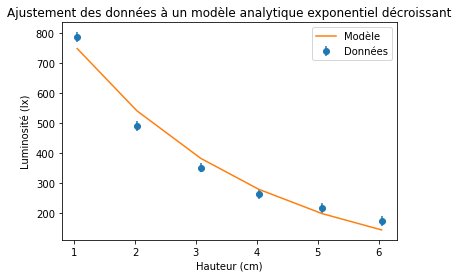

In [7]:
h_i = heights.copy()
I_i = luminosites.copy()
ln_i = np.log(I_i)
sigma_i = dys * ln_i

A = np.sum(h_i * ln_i / sigma_i**2)
B = np.sum(h_i**2 / sigma_i**2)
C = np.sum(h_i / sigma_i**2)
D = np.sum(ln_i / sigma_i**2)
E = np.sum(1 / sigma_i**2)

a = (A * E - D * C) / (B * E - C**2)
b = (D * B - A * C) / (B * E - C**2)

mu = -a
I_0 = np.exp(b)

y_analytique = {
  'I_0': I_0,
  'mu': mu,
}

print('a = {:.2f} cm'.format(a))
print('b = {:.2f}'.format(b))

display(Math(r'I_0 = {:.2f} \, \text{{lx}}'.format(np.exp(b))))
display(Math(r'\mu = {:.2f} \, \text{{cm}}^{{-1}}'.format(mu)))

# Modele
I = I_0 * np.exp(-mu * heights)

plt.errorbar(heights, luminosites, yerr=luminosite_uncertainty, fmt='o', label='Données')
plt.plot(heights, I, label='Modèle')
plt.title('Ajustement des données à un modèle analytique exponentiel décroissant')
plt.xlabel('Hauteur (cm)')
plt.ylabel('Luminosité (lx)')
plt.legend()
plt.show()


L'ajustement par la méthode analytique nous a donné une valeur de $I_0$ égale à $1060.43$ Lx, qui est très proche de la valeur mesurée lorsque aucun objet n'est placé entre la source de lumière et le capteur. De plus, nous avons obtenu une valeur de $\mu = 0.33 \ \text{cm}^{-1}$.

#### Minimisation numérique par minimisation $\chi^2$ avec `scipy`

Maintenant, on s'intéresse à la minimisation de la fonction $\chi^2$ qui va nous permettre de trouver les valeurs de $I_0$ et $\mu$ qui minimisent une fonction de coût donnée.

$$ \chi^2 = \sum_{i=1}^n \left( \frac{y_i - I_0 e^{-\epsilon C x_i}}{\sigma_i} \right)^2 = \sum_{i=1}^n \left( \frac{I_i - I_0 \ e^{-(\mu \ h_i)}}{\sigma_i} \right)^2 $$

avec $x_i$ les hauteurs de liquide, $y_i$ les valeurs de luminosité, et $\sigma_i$ les erreurs sur les valeurs de luminosité.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

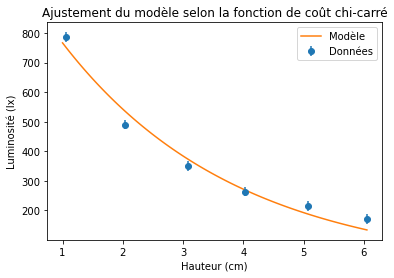

In [8]:
# Fonction du modèle
def f(x, I_O, mu):
  return I_O * np.exp(-mu * x)

# chi-carré
def chi2(params, x, y, dy):
  mu, I_O = params
  return np.sum(((y - f(x, I_O, mu)) / dy)**2)


# Initial guess for I_O
I_O_initial = np.max(luminosites)

# Initial guess for mu
log_y = np.log(luminosites)
slope, _ = np.polyfit(heights, log_y, 1)
mu_initial = -slope

params0 = np.array([mu_initial, I_O_initial])

# Minimisation
result = minimize(chi2, params0, args=(heights, luminosites, luminosite_uncertainty))

mu, I_O = result.x
y_scipy = {
  'I_0': I_O,
  'mu': mu,
}

display(Math(r'I_0 = {:.2f} \, \text{{lx}}'.format(I_O)))
display(Math(r'\mu = {:.2f} \, \text{{cm}}^{{-1}}'.format(mu)))

x = np.linspace(1, heights[len(heights) - 1], 100)
y = f(x, I_O, mu)

plt.errorbar(heights, luminosites, yerr=luminosite_uncertainty, fmt='o', label='Données')
plt.plot(x, y, label='Modèle')
plt.title('Ajustement du modèle selon la fonction de coût chi-carré')
plt.xlabel('Hauteur (cm)')
plt.ylabel('Luminosité (lx)')
plt.legend()
plt.show()


Avec la méthode numérique de minimisation de $\chi^2$, nous obtenons des valeurs approchées de $I_0$ égale à $1084.22$ Lx et de $\mu = 0.35 \ \text{cm}^{-1}$. L'écart entre les valeurs obtenues par la première et la deuxième méthode sera traité dans la partie de comparaison des méthodes.

De même si l'erreur sur la luminosité est $\sigma_i = 1$ Lx, alors on a:

In [9]:
# With sigma_i = 1 Lx

def chi2_sigma_1(params, x, y):
  mu, I_O = params
  return np.sum((y - f(x, I_O, mu))**2)

# Minimisation
result2 = minimize(chi2, params0, args=(heights, luminosites, luminosite_uncertainty))
_mu, _I_O = result2.x
display(Math(r'I_0 = {:.2f} \, \text{{lx}}'.format(_I_O)))
display(Math(r'\mu = {:.2f} \, \text{{cm}}^{{-1}}'.format(_mu)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

D'où on voit que les valeurs $\mu$ et $_0$ trouvées lorsque $\sigma_i = 1$ Lx ne changent pas par rapport à celles trouvées avec $\sigma_i = 16.4$ Lx. Ce qui correspond à l'ajustement précédent où on a linéarisé la relation de Beer-Lambert.

#### Ajustement par QExPy

Finalement, nous utiliserons `qexpy` pour ajuster les données expérimentales. Nous utiliserons la fonction `fit`. De même que pour la fonction de minimisation numérique, nous utiliserons $x_i$ comme les hauteurs de liquide, et $y_i$ comme les valeurs de luminosité.

I_O = 1080 +/- 30 [lx]
mu = 0.35 +/- 0.01 [cm^-1]


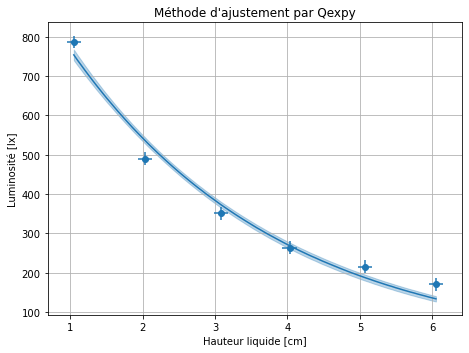

In [10]:
# Fonction du modèle
def f(x, I_O, mu):
  return I_O * qexpy.exp(-mu * x)

qplt.plot(xs, ys)
figure = qplt.get_plot()
figure.title = 'Méthode d\'ajustement par Qexpy'
result = figure.fit(model=f, parguess=[1, 1], parunits=['lx', 'cm^-1'])

I_O = result[0]
mu = result[1]

y_qexpy = {
  'I_0': I_O.value,
  'mu': mu.value,
}

print(I_O)
print(mu)

figure.show()

De la même manière que pour les deux méthodes précédentes, nous avons obtenu une valeur proche de $I_0$, égale à $1080$ Lx, et de $\mu = 0.35 \ \text{cm}^{-1}$. Nous obtenons également une incertitude $\Delta I_0 = \pm 30$, ainsi que $\Delta \mu = \pm 0.01$.

#### Comparaison entre les méthodes d’analyse

On pourra effectuer une comparaison entre les trois méthodes vues précédemment. Pour cela, chaque méthode possède un `dict` contenant les informations des meilleurs paramètres $I_0$ et $\mu$ qui optimisent la fonction $I = I_0 \ e^{-\mu \ h}$.


```python
y_analytique: {'I_0': float, 'mu': float},
y_scipy: {'I_0': float, 'mu': float},
y_qexpy: {'I_0': float, 'mu': float}
```

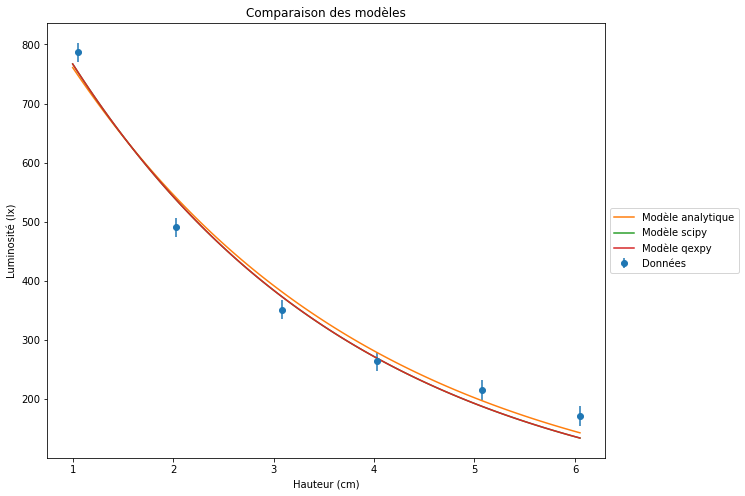

In [11]:
## Comparaison des modèles
x = np.linspace(1, heights[len(heights) - 1], 100)
I_best = lambda I_O, mu, x: I_O * np.exp(-mu * x)

# Methode analytique
I_analytique = I_best(y_analytique['I_0'], y_analytique['mu'], x)

# Methode scipy
I_scipy = I_best(y_scipy['I_0'], y_scipy['mu'], x)

# Methode qexpy
I_qexpy = I_best(y_qexpy['I_0'], y_qexpy['mu'], x)

plt.figure(figsize=(10, 8))
plt.errorbar(heights, luminosites, yerr=luminosite_uncertainty, fmt='o', label='Données')
plt.plot(x, I_analytique, label='Modèle analytique')
plt.plot(x, I_scipy, label='Modèle scipy')
plt.plot(x, I_qexpy, label='Modèle qexpy')
plt.title('Comparaison des modèles')
plt.xlabel('Hauteur (cm)')
plt.ylabel('Luminosité (lx)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


D'après les résultats obtenus, les méthodes numériques avec `scipy` et `qexpy` ont donné des valeurs quasiment identiques, tandis que la méthode analytique a produit des valeurs légèrement différentes.

### Estimation des erreurs sur les paramètres

Pour des modèles linéares et tel comme on a vu dans le cours, on peut calculer les incertitudes sur les paramètres en utilisant $\chi^2$. Dans le cas d'un ajustement linéaire de la forme $y = ax + b$, les erreurs sur les paramètres $a$ et $b$ sont définis par:

$$ B = \sum_{n=1}^{6} \frac{h_i^2}{\sigma_{\Delta \ln(I_i)}^2} \quad \text{et} \quad E = \sum_{n=1}^{6} \frac{1}{\sigma_{\Delta \ln(I_i)}^2} $$

D'où on a:

$$ \Delta a = \frac{\sqrt{ -2 \ \ln(1 - \alpha)}}{\sqrt{B}} = \frac{\sqrt{ -2 \ \ln(1 - \alpha)}}{\sqrt{ \sum_{n=1}^{6} \frac{h_i^2}{\sigma_{\Delta \ln(I_i)}^2} }} $$
$$ \Delta b = \frac{\sqrt{ -2 \ \ln(1 - \alpha)}}{\sqrt{E}} = \frac{\sqrt{ -2 \ \ln(1 - \alpha)}}{\sqrt{ \sum_{n=1}^{6} \frac{1}{\sigma_{\Delta \ln(I_i)}^2} }}  $$

Où le terme $\sqrt{ -2 \ \ln(1 - \alpha)}$ pour une erreur définit à $\alpha = 68.3\%$ vaut $1.52$. Donc il nous suffil donc de calculer les valeurs de $B$ et $E$ pour obtenir les erreurs sur les paramètres.


In [12]:
alpha = 0.683
racine = np.sqrt(-2 * np.log(1 - alpha))

delta_a = racine / np.sqrt(B)
delta_b = racine / np.sqrt(E)

print(result, '\n\n')
print('Erreur sur eC = {:.2f}'.format(delta_a))
print('Erreur sur I_0 = {:.2f} Lx'.format(delta_b))

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
I_O = 1080 +/- 30 [lx],
mu = 0.35 +/- 0.01 [cm^-1]

Correlation Matrix: 
[[1.    0.853]
 [0.853 1.   ]]

chi2/ndof = 22.16/3

--------------- End Fit Results ----------------- 


Erreur sur eC = 0.06
Erreur sur I_0 = 0.15 Lx


La corrélation entre les incertitudes sur $\mu = \epsilon C$ et $I_0$ est positive, ce qui signifie que si l'une augmente, l'autre augmente également, sans qu'il y ait nécessairement une relation causale.

Nous observons que la vraie valeur de $\epsilon C$ est probablement dans l'intervalle $\epsilon C \pm 0.06$, avec un niveau de confiance de $68.3\%$. Les différences sont plus importantes en ce qui concerne l'erreur sur $I_0$. Sa vraie valeur est dans l'intervalle $I_0 \pm 0.15 $ Lx, avec le même niveau de confiance.

Finalement, nous pouvons utiliser les résultats de l'ajustement avec `qexpy` pour $I_0$, $\sigma_{I_0} = 30$ Lx et pour $\epsilon C$, $\sigma_{\epsilon C} = 0.01$. Le coefficient de corrélation obtenu est de $0.853$. Si deux valeurs sont entièrement corrélées, ce coefficient sera égal à 1 ; s'ils sont décorrélés, il sera égal à 0. Ainsi, nous pouvons conclure qu'il existe une forte corrélation entre ces deux paramètres.

### Conclusion

Dans ce TP, nous avons étudié la loi de Beer-Lambert en réalisant une expérience de mesure de luminosité à partir de différentes hauteurs d'un liquide choisi (soda) de couleur bleue. Ainsi, nous avons ajusté ces mesures à un modèle en utilisant plusieurs méthodes : la minimisation du $\chi^2$ de manière analytique ainsi que numérique avec `scipy`, et enfin un ajustement avec `qexpy`. En comparant les trois méthodes utilisées, nous avons constaté que les deux meilleures sont celles de `scipy` et `qexpy`, car elles se rapprochent le plus des données mesurées sans entraîner de problèmes de *'overfitting'*.

Enfin, nous avons pu mettre en évidence la corrélation entre les erreurs de $\epsilon C$ et $I_0$ en constatant une forte corrélation entre ces deux valeurs. Cela nous donne une idée de la précision de nos estimations des valeurs obtenues par les trois méthodes utilisées.